### 4ая Практическая работа. Компьютерный статистический анализ данных

Датасет - Компьютерная томография лёгких. Обнаружение пневмонии. Когда специалисты анализируют снимки, для выявления пневмонии служат белые пятная в лёгких (инфильтраты).

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [3]:
from tensorflow import keras

### Знакомство с данными

Выведем изображения с пневмонией и без, чтобы увидеть разницу

In [8]:
X = []
image = keras.preprocessing.image.load_img('../input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0125-0001.jpeg',
                                           color_mode = 'grayscale', target_size = (128,128))
X.append(keras.preprocessing.image.img_to_array(image))

image = keras.preprocessing.image.load_img('../input/chest-xray-pneumonia/chest_xray/train/NORMAL/IM-0180-0001.jpeg',
                                           color_mode = 'grayscale', target_size = (128,128))
X.append(keras.preprocessing.image.img_to_array(image))

In [9]:
image = keras.preprocessing.image.load_img('../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1005_virus_1688.jpeg',
                                           color_mode = "grayscale", target_size = (128,128))
X.append(keras.preprocessing.image.img_to_array(image))

image = keras.preprocessing.image.load_img('../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/person1018_virus_1706.jpeg',
                                          color_mode = "grayscale", target_size = (128,128))
X.append(keras.preprocessing.image.img_to_array(image))

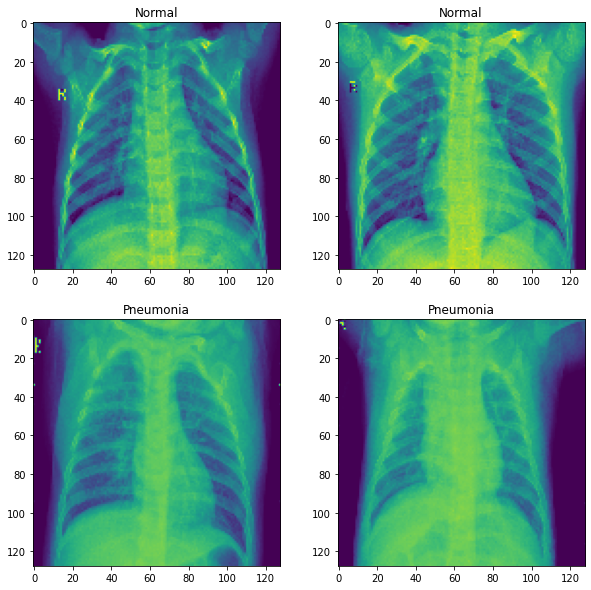

In [10]:
fig = plt.figure(figsize = (10,10))
for i in range(4):
    plt.subplot(220+i+1)
    plt.imshow (X[i])
    if i < 2 :
        plt.title('Normal')
    else :
        plt.title('Pneumonia')

Разница заметна. У снимков с пневмонией  больше так называемых белых пятен.

Во врачебные подробности нам всё же вдаваться не нужно, нам нужно построить CNN

### Загружаем данные.

In [4]:
train_normal = "../input/chest-xray-pneumonia/chest_xray/train/NORMAL"
train_pneumonia = "../input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA"
train_path = "../input/chest-xray-pneumonia/chest_xray/train"

test_normal = "../input/chest-xray-pneumonia/chest_xray/test/NORMAL"
test_pneumonia = "../input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA"
test_path = "../input/chest-xray-pneumonia/chest_xray/test"

val_normal = "../input/chest-xray-pneumonia/chest_xray/val/NORMAL/"
val_pneumonia = "../input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/"
val_path = "../input/chest-xray-pneumonia/chest_xray/val"

In [5]:
TRAIN_NORMAL    = os.listdir(train_normal)
TRAIN_PNEUMONIA = os.listdir(train_pneumonia)

TEST_NORMAL     = os.listdir(test_normal)
TEST_PNEUMONIA  = os.listdir(test_pneumonia)

VAL_NORMAL      = os.listdir(val_normal)
VAL_PNEUMONIA   = os.listdir(val_pneumonia)

CLASSES = ['NORMAL','PNEUMONIA']

In [6]:
from keras.preprocessing.image import ImageDataGenerator

In [7]:
train_generation = ImageDataGenerator(rescale = 1.0 / 255.0,
                                      zoom_range = 0.2)

test_generation = ImageDataGenerator(rescale = 1.0 / 255.0)

valid_generation = ImageDataGenerator(rescale = 1.0 / 255.0)

In [8]:
train_dataset = train_generation.flow_from_directory(directory = train_path,
                                                     target_size = (128, 128),
                                                     class_mode = 'categorical',
                                                     batch_size = 64)

valid_dataset = valid_generation.flow_from_directory(directory = val_path,
                                                     target_size = (128, 128),
                                                     class_mode = 'categorical',
                                                     batch_size = 64)

test_dataset = test_generation.flow_from_directory(directory = test_path,
                                                    target_size = (128, 128),
                                                    class_mode = 'categorical',
                                                    batch_size = 64, 
                                                    shuffle = True)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [9]:
train_dataset.class_indices

valid_dataset.class_indices

test_dataset.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

Здесь значения пикселей варьируются от 0 до 255. На вход CNN сеть такое воспринимать не будет. Нормализовали от 0 до 1

Подготовительный этап можно считать закрытым🎉

### Создание моделей для обучения

In [13]:
from keras.models import Sequential
from keras.layers import *
from keras import optimizers

#### model_1

In [18]:
model_1 = Sequential()

model_1.add(Conv2D(32, (3, 3), padding = 'same', input_shape = (128,128,3), activation = 'relu'))

model_1.add(MaxPooling2D(pool_size = (2,2), strides = 2))

model_1.add(Flatten())

model_1.add(Dense(128, activation='relu'))

model_1.add(Dropout(0.3))

model_1.add(Dense(2, activation='softmax'))

model_1.compile(optimizer = 'SGD',loss= 'categorical_crossentropy' , metrics = ['accuracy'])

In [19]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               16777344  
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
Total params: 16,778,498
Trainable params: 16,778,498
Non-trainable params: 0
____________________________________________

#### model_2

In [20]:
model_2 = Sequential()

model_2.add(Conv2D(32, (3, 3), padding = 'same', input_shape = (128,128,3), activation = 'relu'))
model_2.add(MaxPooling2D(pool_size = (2,2), strides = 2))

model_2.add(Conv2D(64, (4, 4), padding = 'same', activation = 'relu'))
model_2.add(MaxPooling2D(pool_size = (2,2), strides = 2))

model_2.add(Flatten())
model_2.add(Dropout(0.3))
model_2.add(Dense(128, activation='relu'))
model_2.add(Dropout(0.3))
model_2.add(Dense(2, activation='softmax'))

model_2.compile(optimizer = 'adam',loss= 'categorical_crossentropy' , metrics = ['accuracy'])

In [21]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        32832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 65536)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)              

#### model_3

In [22]:
model_3 = Sequential()

model_3.add(Conv2D(32, (3, 3), padding = 'same', input_shape = (128,128,3), activation = 'relu'))
model_3.add(MaxPooling2D(pool_size = (2,2), strides = 2))

model_3.add(Conv2D(64, (4, 4), padding = 'same', activation = 'relu'))
model_3.add(MaxPooling2D(pool_size = (2,2), strides = 2))

model_3.add(Flatten())
model_3.add(Dense(256, activation='relu'))
model_3.add(BatchNormalization())
model_3.add(Dense(128, activation='relu'))
model_3.add(BatchNormalization())
model_3.add(Dense(2, activation='softmax'))

model_3.compile(optimizer = 'Adam',loss= 'categorical_crossentropy' , metrics = ['accuracy'])

In [23]:
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 64)        32832     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               16777472  
_________________________________________________________________
batch_normalization (BatchNo (None, 256)              

#### model_4

In [24]:
model_4 = Sequential()

model_4.add(Conv2D(32, (3, 3), 
                   padding = 'same', 
                   input_shape = (128,128,3), 
                   activation = 'relu'))
model_4.add(MaxPooling2D(pool_size = (2,2), strides = 2))

model_4.add(Conv2D(64, (4, 4), padding = 'same', activation = 'relu'))
model_4.add(MaxPooling2D(pool_size = (2,2), strides = 2))

model_4.add(Flatten())
model_4.add(Dense(256, activation='relu'))
model_4.add(Dropout(0.4))
model_4.add(Dense(128, activation='relu'))
model_4.add(Dropout(0.3))
model_4.add(Dense(2, activation='softmax'))

model_4.compile(optimizer = 'adam',loss= 'categorical_crossentropy' , metrics = ['accuracy'])

In [25]:
model_4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 64, 64, 64)        32832     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               16777472  
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)              

#### model_5

In [26]:
model_5 = Sequential()

model_5.add(Conv2D(32, (3, 3), activation = "relu", input_shape = (128, 128, 3)))
model_5.add(MaxPooling2D((2, 2), strides = 2))

model_5.add(Conv2D(64, (3, 3), activation = "relu"))
model_5.add(MaxPooling2D((2, 2), strides = 2))

model_5.add(Conv2D(128, (3, 3), activation = "relu"))
model_5.add(MaxPooling2D((2, 2), strides = 2))

model_5.add(Conv2D(128, (3, 3), activation = "relu"))
model_5.add(MaxPooling2D((2, 2), strides = 2))

model_5.add(Flatten())
model_5.add(Dropout(0.3))
model_5.add(Dense(512, activation = "relu"))
model_5.add(Dropout(0.4))
model_5.add(Dense(2, activation = "softmax"))

model_5.compile(loss = "categorical_crossentropy",
             optimizer = optimizers.RMSprop(lr = 1e-4),
             metrics = ["accuracy"])

In [27]:
model_5.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 12, 12, 128)      

#### model_vgg

In [14]:
# function for creating a vgg block
def vgg_block(layer_in, n_filters, n_conv):
    for _ in range(n_conv):
        layer_in = Conv2D(n_filters, (3,3), padding='same', activation='relu')(layer_in)
        # add max pooling layer
        layer_in = MaxPooling2D((2,2), strides=(2,2))(layer_in)
    
    flat = Flatten()(layer_in)
    d_1 = Dense(256, activation = 'relu')(flat)
    layer_out = Dense(2, activation = 'softmax')(d_1)
    return layer_out

In [15]:
visible_vgg = Input(shape=(128, 128, 3))
# add vgg module
layer_vgg = vgg_block(visible_vgg, 64, 3)
# create model
model_vgg = keras.Model(inputs=visible_vgg, outputs=layer_vgg)

model_vgg.compile(optimizer = 'adam', loss= 'categorical_crossentropy', metrics = ['accuracy'])

In [16]:
model_vgg.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 128, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0     

#### model_inc

In [17]:
def inception_module(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
    # 1x1 conv
    conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
    # 3x3 conv
    conv3 = Conv2D(f2_in, (1,1), padding='same', activation='relu')(layer_in)
    conv3 = Conv2D(f2_out, (3,3), padding='same', activation='relu')(conv3)
    # 5x5 conv
    conv5 = Conv2D(f3_in, (1,1), padding='same', activation='relu')(layer_in)
    conv5 = Conv2D(f3_out, (5,5), padding='same', activation='relu')(conv5)
    # 3x3 max pooling
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
    pool = Conv2D(f4_out, (1,1), padding='same', activation='relu')(pool)
    # concatenate filters, assumes filters/channels last
    middle = concatenate([conv1, conv3, conv5, pool], axis=-1)
    
    flat = Flatten()(middle)
    d_1 = Dense(128, activation = 'relu')(flat)
    layer_out = Dense(2, activation = 'softmax')(d_1)
    return layer_out

In [18]:
visible_inc = Input(shape = (128, 128, 3))

layer_inc = inception_module(visible_inc, 32, 64, 128, 16, 32, 64)

model_inc = keras.Model(inputs = visible_inc, outputs = layer_inc)

model_inc.compile(optimizer = 'adam',
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])

In [19]:
model_inc.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 128, 128, 64) 256         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 128, 128, 16) 64          input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 128, 128, 3)  0           input_2[0][0]                    
____________________________________________________________________________________________

#### model_res

In [20]:
def residual_module(layer_in, n_filters):
    merge_input = layer_in
    
    # check if the number of filters needs to be increase, assumes channels last format
    if layer_in.shape[-1] != n_filters:
        merge_input = Conv2D(n_filters, (1,1), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
        
    # conv1
    conv1 = Conv2D(n_filters, (3,3), padding='same', activation='relu', kernel_initializer='he_normal')(layer_in)
    
    # conv2
    conv2 = Conv2D(n_filters, (3,3), padding='same', activation='linear', kernel_initializer='he_normal')(conv1)
    
    middle = add([conv2, merge_input])
    middle = Activation('relu')(middle)
    
    flat = Flatten()(middle)
    d_2 = Dense(128, activation = 'relu')(flat)
    layer_out = Dense(2, activation = 'softmax')(d_2)
    
    return layer_out

In [21]:
visible_res = Input(shape = (128, 128, 3))

layer_res = residual_module(visible_res, 64)

model_res = keras.Model(inputs = visible_res, outputs = layer_res)

model_res.compile(optimizer = 'adam',
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])

In [22]:
model_res.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 128, 128, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 128, 128, 64) 36928       conv2d_10[0][0]                  
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 128, 128, 64) 256         input_3[0][0]                    
____________________________________________________________________________________________

#### model_dense

In [23]:
def dense_factor(layer_in, n_filters):
    batcnorm = BatchNormalization()(layer_in)
    conv2 = Conv2D(n_filters, (3,3), padding='same')(batcnorm)
    layer_out = Activation('relu')(conv2)
    
    return layer_out

def dense_block(layer_in, n_filters):
    concatenated_inputs = layer_in
    for _ in range(3):
        x = dense_factor(concatenated_inputs, n_filters)
        
    concatenated_inputs = concatenate([concatenated_inputs, x], axis=3)    
    flat = Flatten()(concatenated_inputs)
    d_1 = Dense(128, activation = 'relu')(flat)
    layer_out = Dense(2, activation = 'softmax')(d_1)
    
    return layer_out

In [24]:
visible_dense = Input(shape = (128, 128, 3))

layer_dense = dense_block(visible_dense, 32)

model_dense = keras.Model(inputs = visible_dense, outputs = layer_dense)

model_dense.compile(optimizer = 'adam',
                  loss = 'categorical_crossentropy',
                  metrics = ['accuracy'])

In [25]:
model_dense.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 128, 128, 3)  12          input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_14 (Conv2D)              (None, 128, 128, 32) 896         batch_normalization_2[0][0]      
__________________________________________________________________________________________________
activation_3 (Activation)       (None, 128, 128, 32) 0           conv2d_14[0][0]                  
____________________________________________________________________________________________

#### model_vgg16

In [27]:
from tensorflow.keras.applications import vgg16

In [28]:
vgg_conv = vgg16.VGG16(weights = 'imagenet', include_top = False, input_shape = (128, 128, 3))

58892288/58889256 [==============================] - 1s 0us/step


In [29]:
for layer in vgg_conv.layers:
    if layer.name in ['block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_pool']:
        set_trainable = True
    else:
        layer.trainable = False

In [30]:
model_vgg_16 = keras.Sequential([
  vgg_conv,
  Flatten(),
  Dense(256, activation = 'relu'),
  Dropout(0.2),
  Dense(2, activation = 'softmax')
])

In [31]:
model_vgg_16.compile(optimizer = 'adam',
                     loss = 'categorical_crossentropy',
                     metrics = ['accuracy'])

In [32]:
model_vgg_16.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 514       
Total params: 16,812,610
Trainable params: 9,177,346
Non-trainable params: 7,635,264
_________________________________________________________________


### Обучение моделей

In [33]:
from keras.callbacks import ReduceLROnPlateau
reduce = ReduceLROnPlateau(monitor = 'loss', patience  = 3)

#### model_1

In [47]:
history_1 = model_1.fit(train_dataset,
                    epochs=7,
                    validation_data=valid_dataset,
                    batch_size=128,
                    callbacks = [reduce],
                    verbose=1)

Epoch 1/7
82/82 [==============================] - 113s 1s/step - loss: 0.6208 - accuracy: 0.7143 - val_loss: 0.6727 - val_accuracy: 0.5000
Epoch 2/7
82/82 [==============================] - 74s 903ms/step - loss: 0.5123 - accuracy: 0.7606 - val_loss: 0.9164 - val_accuracy: 0.5000
Epoch 3/7
82/82 [==============================] - 73s 894ms/step - loss: 0.4375 - accuracy: 0.7905 - val_loss: 0.7408 - val_accuracy: 0.6250
Epoch 4/7
82/82 [==============================] - 74s 906ms/step - loss: 0.3862 - accuracy: 0.8296 - val_loss: 0.5023 - val_accuracy: 0.8125
Epoch 5/7
82/82 [==============================] - 75s 915ms/step - loss: 0.3527 - accuracy: 0.8387 - val_loss: 0.6173 - val_accuracy: 0.7500
Epoch 6/7
82/82 [==============================] - 74s 909ms/step - loss: 0.2958 - accuracy: 0.8803 - val_loss: 0.6154 - val_accuracy: 0.7500
Epoch 7/7
82/82 [==============================] - 74s 905ms/step - loss: 0.2977 - accuracy: 0.8705 - val_loss: 0.6854 - val_accuracy: 0.7500


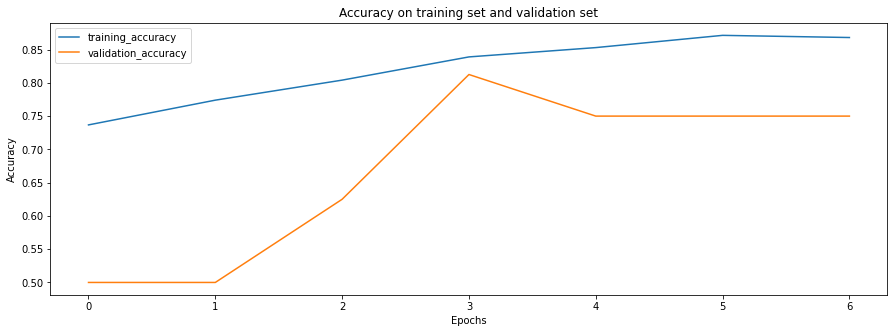

In [48]:
fig = plt.figure(figsize = (15,5))
plt.plot(history_1.history['accuracy'])                   # accuracy for the training set
plt.plot(history_1.history['val_accuracy'])               # sccuracy for the validate set
plt.legend(['training_accuracy', 'validation_accuracy'])
plt.title('Accuracy on training set and validation set')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [49]:
model_1.evaluate(test_dataset, verbose = 2)

10/10 - 10s - loss: 0.4152 - accuracy: 0.8253


[0.4152357578277588, 0.8253205418586731]

#### model_2

In [50]:
history_2 = model_2.fit(train_dataset,
                    epochs=7,
                    validation_data=valid_dataset,
                    callbacks = [reduce],
                    batch_size = 64)

Epoch 1/7
82/82 [==============================] - 78s 945ms/step - loss: 1.2700 - accuracy: 0.6919 - val_loss: 0.6011 - val_accuracy: 0.6875
Epoch 2/7
82/82 [==============================] - 78s 945ms/step - loss: 0.3064 - accuracy: 0.8630 - val_loss: 0.5123 - val_accuracy: 0.7500
Epoch 3/7
82/82 [==============================] - 76s 929ms/step - loss: 0.2449 - accuracy: 0.8938 - val_loss: 0.3852 - val_accuracy: 0.8750
Epoch 4/7
82/82 [==============================] - 74s 896ms/step - loss: 0.2109 - accuracy: 0.9169 - val_loss: 0.8094 - val_accuracy: 0.6875
Epoch 5/7
82/82 [==============================] - 74s 905ms/step - loss: 0.1764 - accuracy: 0.9268 - val_loss: 0.5574 - val_accuracy: 0.7500
Epoch 6/7
82/82 [==============================] - 73s 893ms/step - loss: 0.1842 - accuracy: 0.9315 - val_loss: 0.4494 - val_accuracy: 0.8125
Epoch 7/7
82/82 [==============================] - 74s 905ms/step - loss: 0.1789 - accuracy: 0.9288 - val_loss: 0.5769 - val_accuracy: 0.7500


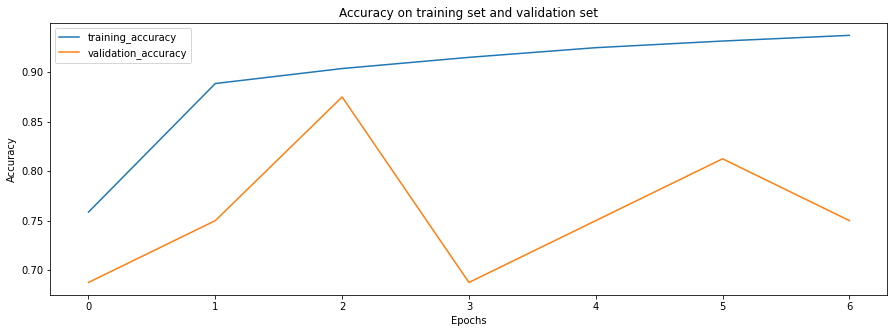

In [51]:
fig = plt.figure(figsize = (15,5))
plt.plot(history_2.history['accuracy'])                   # accuracy for the training set
plt.plot(history_2.history['val_accuracy'])               # sccuracy for the validate set
plt.legend(['training_accuracy', 'validation_accuracy'])
plt.title('Accuracy on training set and validation set')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [52]:
model_2.evaluate(test_dataset, verbose = 2)

10/10 - 6s - loss: 0.5407 - accuracy: 0.8285


[0.5407023429870605, 0.8285256624221802]

#### model_3

In [53]:
history_3 = model_3.fit(train_dataset,
                    epochs=7,
                    validation_data=valid_dataset,
                    callbacks = [reduce],
                    batch_size = 64)

Epoch 1/7
82/82 [==============================] - 78s 939ms/step - loss: 0.4493 - accuracy: 0.8242 - val_loss: 4.4245 - val_accuracy: 0.5000
Epoch 2/7
82/82 [==============================] - 76s 920ms/step - loss: 0.1775 - accuracy: 0.9441 - val_loss: 0.6653 - val_accuracy: 0.6250
Epoch 3/7
82/82 [==============================] - 73s 892ms/step - loss: 0.1474 - accuracy: 0.9435 - val_loss: 9.7102 - val_accuracy: 0.5000
Epoch 4/7
82/82 [==============================] - 73s 892ms/step - loss: 0.1343 - accuracy: 0.9525 - val_loss: 5.7099 - val_accuracy: 0.5000
Epoch 5/7
82/82 [==============================] - 74s 895ms/step - loss: 0.1174 - accuracy: 0.9599 - val_loss: 7.3366 - val_accuracy: 0.5000
Epoch 6/7
82/82 [==============================] - 74s 907ms/step - loss: 0.1169 - accuracy: 0.9574 - val_loss: 14.7792 - val_accuracy: 0.5000
Epoch 7/7
82/82 [==============================] - 74s 902ms/step - loss: 0.1099 - accuracy: 0.9585 - val_loss: 3.0789 - val_accuracy: 0.5000


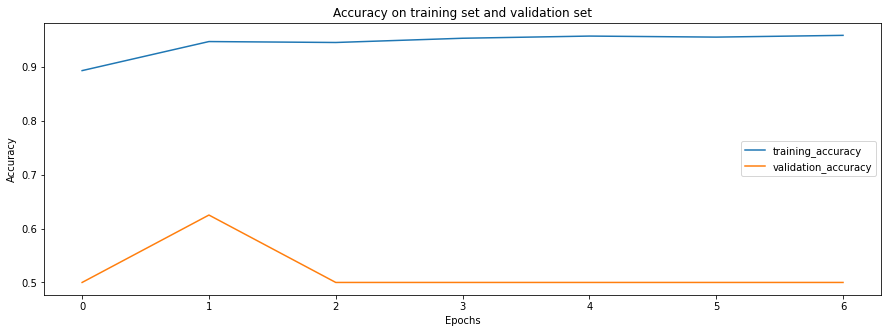

In [54]:
fig = plt.figure(figsize = (15,5))
plt.plot(history_3.history['accuracy'])                   # accuracy for the training set
plt.plot(history_3.history['val_accuracy'])               # sccuracy for the validate set
plt.legend(['training_accuracy', 'validation_accuracy'])
plt.title('Accuracy on training set and validation set')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [55]:
model_3.evaluate(test_dataset, verbose = 2)

10/10 - 6s - loss: 2.4817 - accuracy: 0.4631


[2.481745958328247, 0.4631410241127014]

#### model_4

In [56]:
history_4 = model_4.fit(train_dataset,
                    epochs=7,
                    validation_data=valid_dataset,
                    callbacks = [reduce],
                    batch_size = 64)

Epoch 1/7
82/82 [==============================] - 75s 903ms/step - loss: 0.5739 - accuracy: 0.7450 - val_loss: 0.4855 - val_accuracy: 0.7500
Epoch 2/7
82/82 [==============================] - 73s 893ms/step - loss: 0.2451 - accuracy: 0.9014 - val_loss: 0.7317 - val_accuracy: 0.7500
Epoch 3/7
82/82 [==============================] - 74s 899ms/step - loss: 0.2152 - accuracy: 0.9189 - val_loss: 1.1159 - val_accuracy: 0.6250
Epoch 4/7
82/82 [==============================] - 73s 893ms/step - loss: 0.1858 - accuracy: 0.9181 - val_loss: 1.0371 - val_accuracy: 0.6875
Epoch 5/7
82/82 [==============================] - 73s 890ms/step - loss: 0.1882 - accuracy: 0.9242 - val_loss: 0.5473 - val_accuracy: 0.6875
Epoch 6/7
82/82 [==============================] - 74s 902ms/step - loss: 0.1883 - accuracy: 0.9244 - val_loss: 0.8940 - val_accuracy: 0.6875
Epoch 7/7
82/82 [==============================] - 73s 890ms/step - loss: 0.1739 - accuracy: 0.9289 - val_loss: 1.1210 - val_accuracy: 0.6875


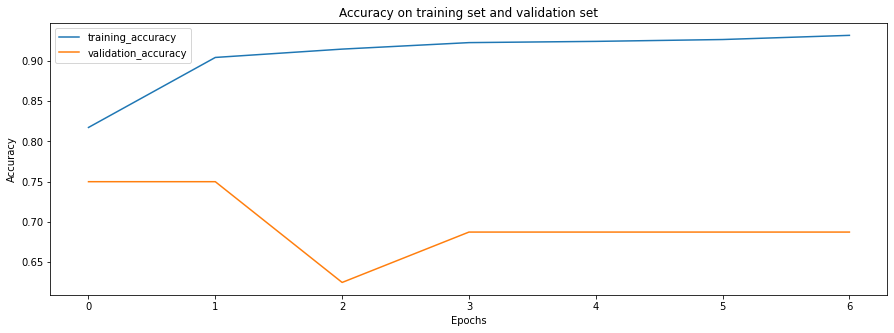

In [57]:
fig = plt.figure(figsize = (15,5))
plt.plot(history_4.history['accuracy'])                   # accuracy for the training set
plt.plot(history_4.history['val_accuracy'])               # sccuracy for the validate set
plt.legend(['training_accuracy', 'validation_accuracy'])
plt.title('Accuracy on training set and validation set')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [58]:
model_4.evaluate(test_dataset, verbose = 2)

10/10 - 6s - loss: 0.6511 - accuracy: 0.8702


[0.6511088609695435, 0.870192289352417]

#### model_5

In [59]:
history_5 = model_5.fit(train_dataset,
                    epochs=7,
                    batch_size=64,
                    validation_data=valid_dataset,
                    callbacks=[reduce])

Epoch 1/7
82/82 [==============================] - 75s 889ms/step - loss: 0.5823 - accuracy: 0.7107 - val_loss: 0.5627 - val_accuracy: 0.6250
Epoch 2/7
82/82 [==============================] - 74s 899ms/step - loss: 0.4057 - accuracy: 0.8229 - val_loss: 0.7504 - val_accuracy: 0.6250
Epoch 3/7
82/82 [==============================] - 78s 955ms/step - loss: 0.2809 - accuracy: 0.8823 - val_loss: 0.4665 - val_accuracy: 0.8750
Epoch 4/7
82/82 [==============================] - 74s 903ms/step - loss: 0.2482 - accuracy: 0.8942 - val_loss: 1.1326 - val_accuracy: 0.5625
Epoch 5/7
82/82 [==============================] - 75s 911ms/step - loss: 0.2312 - accuracy: 0.9022 - val_loss: 0.8909 - val_accuracy: 0.6250
Epoch 6/7
82/82 [==============================] - 74s 909ms/step - loss: 0.2219 - accuracy: 0.9088 - val_loss: 0.7526 - val_accuracy: 0.6250
Epoch 7/7
82/82 [==============================] - 75s 910ms/step - loss: 0.2034 - accuracy: 0.9156 - val_loss: 0.6653 - val_accuracy: 0.6875


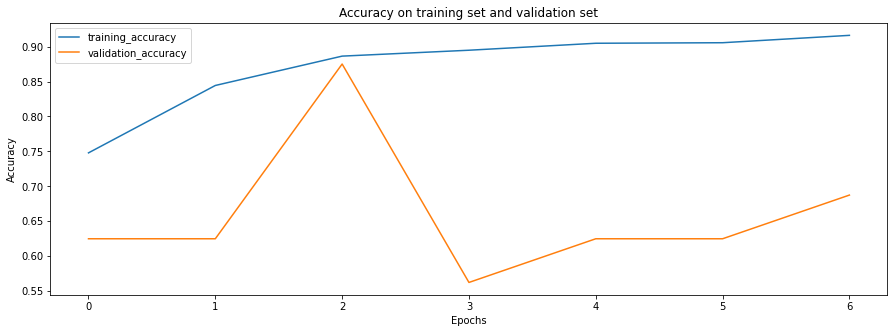

In [60]:
fig = plt.figure(figsize = (15,5))
plt.plot(history_5.history['accuracy'])                   # accuracy for the training set
plt.plot(history_5.history['val_accuracy'])               # sccuracy for the validate set
plt.legend(['training_accuracy', 'validation_accuracy'])
plt.title('Accuracy on training set and validation set')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [61]:
model_5.evaluate(test_dataset, verbose = 2)

10/10 - 6s - loss: 0.2800 - accuracy: 0.9022


[0.2800453007221222, 0.9022436141967773]

#### model_vgg

In [34]:
EPOCHS = 7
BATCH_SIZE = 64

history_vgg = model_vgg.fit(train_dataset,
                            epochs = EPOCHS,
                            batch_size = BATCH_SIZE,
                            validation_data = valid_dataset,
                            verbose = 2)

Epoch 1/7
82/82 - 129s - loss: 0.5247 - accuracy: 0.7755 - val_loss: 0.8513 - val_accuracy: 0.6250
Epoch 2/7
82/82 - 77s - loss: 0.2753 - accuracy: 0.8865 - val_loss: 0.3520 - val_accuracy: 0.7500
Epoch 3/7
82/82 - 78s - loss: 0.1938 - accuracy: 0.9214 - val_loss: 1.1098 - val_accuracy: 0.5625
Epoch 4/7
82/82 - 76s - loss: 0.1817 - accuracy: 0.9293 - val_loss: 0.2232 - val_accuracy: 0.8750
Epoch 5/7
82/82 - 77s - loss: 0.1607 - accuracy: 0.9365 - val_loss: 1.0722 - val_accuracy: 0.6250
Epoch 6/7
82/82 - 76s - loss: 0.1653 - accuracy: 0.9354 - val_loss: 0.7040 - val_accuracy: 0.7500
Epoch 7/7
82/82 - 76s - loss: 0.1331 - accuracy: 0.9526 - val_loss: 0.7956 - val_accuracy: 0.6875


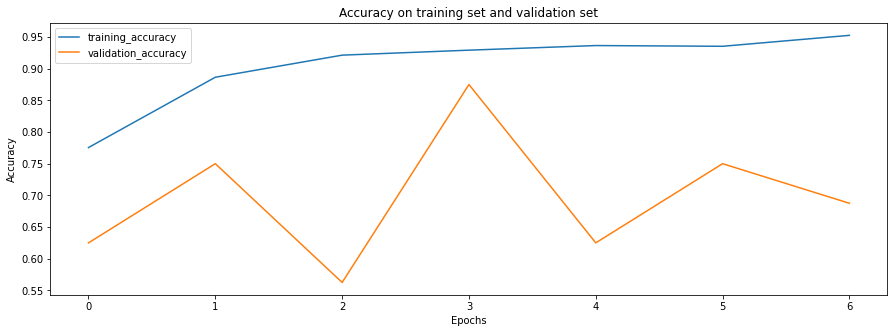

In [35]:
fig = plt.figure(figsize = (15,5))
plt.plot(history_vgg.history['accuracy'])                   # accuracy for the training set
plt.plot(history_vgg.history['val_accuracy'])               # sccuracy for the validate set
plt.legend(['training_accuracy', 'validation_accuracy'])
plt.title('Accuracy on training set and validation set')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [36]:
model_vgg.evaluate(test_dataset, verbose = 2)

10/10 - 13s - loss: 0.5851 - accuracy: 0.7628


[0.5850883722305298, 0.7628205418586731]

#### model_inc

In [37]:
EPOCHS = 7
BATCH_SIZE = 64

history_inc = model_inc.fit(train_dataset, 
                            epochs = EPOCHS,
                            batch_size = BATCH_SIZE,
                            validation_data = valid_dataset,
                            verbose = 1,
                            callbacks = [reduce])

Epoch 1/7
82/82 [==============================] - 105s 1s/step - loss: 38.9812 - accuracy: 0.6711 - val_loss: 0.7156 - val_accuracy: 0.7500
Epoch 2/7
82/82 [==============================] - 99s 1s/step - loss: 0.2992 - accuracy: 0.8871 - val_loss: 0.8750 - val_accuracy: 0.6250
Epoch 3/7
82/82 [==============================] - 99s 1s/step - loss: 0.4378 - accuracy: 0.8624 - val_loss: 0.2669 - val_accuracy: 0.9375
Epoch 4/7
82/82 [==============================] - 98s 1s/step - loss: 0.3630 - accuracy: 0.8893 - val_loss: 0.3355 - val_accuracy: 0.9375
Epoch 5/7
82/82 [==============================] - 98s 1s/step - loss: 0.2862 - accuracy: 0.9007 - val_loss: 0.8242 - val_accuracy: 0.6875
Epoch 6/7
82/82 [==============================] - 98s 1s/step - loss: 0.1885 - accuracy: 0.9331 - val_loss: 0.5472 - val_accuracy: 0.7500
Epoch 7/7
82/82 [==============================] - 99s 1s/step - loss: 0.1878 - accuracy: 0.9279 - val_loss: 0.8278 - val_accuracy: 0.6875


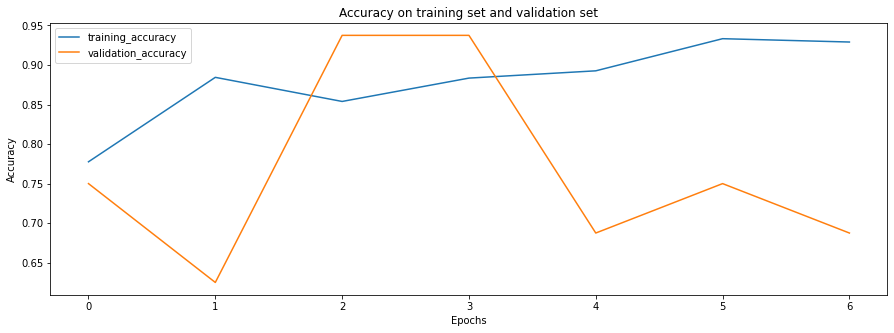

In [38]:
fig = plt.figure(figsize = (15,5))
plt.plot(history_inc.history['accuracy'])                   # accuracy for the training set
plt.plot(history_inc.history['val_accuracy'])               # sccuracy for the validate set
plt.legend(['training_accuracy', 'validation_accuracy'])
plt.title('Accuracy on training set and validation set')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [39]:
model_inc.evaluate(test_dataset, verbose = 2)

10/10 - 12s - loss: 0.4909 - accuracy: 0.8317


[0.49093320965766907, 0.8317307829856873]

#### model_res

In [40]:
EPOCHS = 7
BATCH_SIZE = 64

history_res = model_res.fit(train_dataset, 
                            epochs = EPOCHS,
                            batch_size = BATCH_SIZE,
                            validation_data = valid_dataset,
                            verbose = 2,
                            callbacks = [reduce])

Epoch 1/7
82/82 - 77s - loss: 15.1243 - accuracy: 0.7730 - val_loss: 5.8992 - val_accuracy: 0.6875
Epoch 2/7
82/82 - 75s - loss: 0.3069 - accuracy: 0.9020 - val_loss: 0.4694 - val_accuracy: 0.8125
Epoch 3/7
82/82 - 78s - loss: 0.2166 - accuracy: 0.9149 - val_loss: 0.4470 - val_accuracy: 0.7500
Epoch 4/7
82/82 - 78s - loss: 0.1926 - accuracy: 0.9172 - val_loss: 0.2567 - val_accuracy: 0.8750
Epoch 5/7
82/82 - 77s - loss: 0.1839 - accuracy: 0.9260 - val_loss: 0.3460 - val_accuracy: 0.8125
Epoch 6/7
82/82 - 79s - loss: 0.1769 - accuracy: 0.9275 - val_loss: 0.4422 - val_accuracy: 0.8125
Epoch 7/7
82/82 - 78s - loss: 0.1560 - accuracy: 0.9354 - val_loss: 0.2856 - val_accuracy: 0.8125


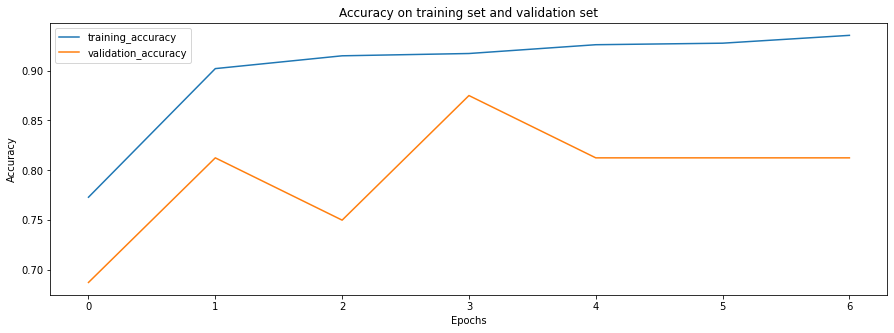

In [41]:
fig = plt.figure(figsize = (15,5))
plt.plot(history_res.history['accuracy'])                   # accuracy for the training set
plt.plot(history_res.history['val_accuracy'])               # sccuracy for the validate set
plt.legend(['training_accuracy', 'validation_accuracy'])
plt.title('Accuracy on training set and validation set')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [42]:
model_res.evaluate(test_dataset, verbose = 2)

10/10 - 7s - loss: 0.8936 - accuracy: 0.8061


[0.8936364650726318, 0.8060897588729858]

#### model_dense

In [43]:
EPOCHS = 7
BATCH_SIZE = 64

history_dense = model_dense.fit(train_dataset, 
                            epochs = EPOCHS,
                            batch_size = BATCH_SIZE,
                            validation_data = valid_dataset,
                            verbose = 2,
                            callbacks = [reduce])

Epoch 1/7
82/82 - 79s - loss: 10.8029 - accuracy: 0.8169 - val_loss: 8.9664 - val_accuracy: 0.5625
Epoch 2/7
82/82 - 77s - loss: 0.9785 - accuracy: 0.8976 - val_loss: 0.1156 - val_accuracy: 0.9375
Epoch 3/7
82/82 - 78s - loss: 0.7331 - accuracy: 0.9153 - val_loss: 0.4817 - val_accuracy: 0.8125
Epoch 4/7
82/82 - 76s - loss: 0.4493 - accuracy: 0.9304 - val_loss: 4.6932 - val_accuracy: 0.6250
Epoch 5/7
82/82 - 76s - loss: 0.7489 - accuracy: 0.9109 - val_loss: 6.8458 - val_accuracy: 0.6250
Epoch 6/7
82/82 - 77s - loss: 0.5597 - accuracy: 0.9270 - val_loss: 1.6568 - val_accuracy: 0.7500
Epoch 7/7
82/82 - 78s - loss: 0.7677 - accuracy: 0.9156 - val_loss: 1.4277 - val_accuracy: 0.8125


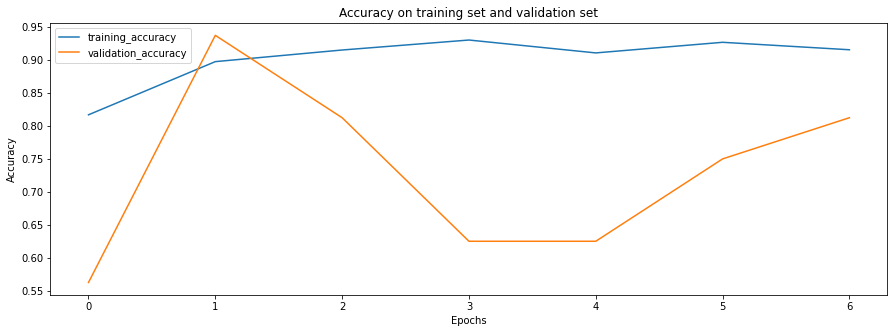

In [44]:
fig = plt.figure(figsize = (15,5))
plt.plot(history_dense.history['accuracy'])                   # accuracy for the training set
plt.plot(history_dense.history['val_accuracy'])               # sccuracy for the validate set
plt.legend(['training_accuracy', 'validation_accuracy'])
plt.title('Accuracy on training set and validation set')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [45]:
model_dense.evaluate(test_dataset, verbose = 2)

10/10 - 7s - loss: 1.1633 - accuracy: 0.8942


[1.1633062362670898, 0.8942307829856873]

#### model_vgg_16

In [46]:
EPOCHS = 7
BATCH_SIZE = 64

history_vgg_16 = model_vgg_16.fit(train_dataset, 
                            epochs = EPOCHS,
                            batch_size = BATCH_SIZE,
                            validation_data = valid_dataset,
                            verbose = 2,
                            callbacks = [reduce])

Epoch 1/7
82/82 - 205s - loss: 0.3745 - accuracy: 0.8537 - val_loss: 1.3353 - val_accuracy: 0.5000
Epoch 2/7
82/82 - 185s - loss: 0.1189 - accuracy: 0.9555 - val_loss: 0.2418 - val_accuracy: 0.9375
Epoch 3/7
82/82 - 185s - loss: 0.1222 - accuracy: 0.9523 - val_loss: 0.3384 - val_accuracy: 0.8125
Epoch 4/7
82/82 - 185s - loss: 0.0776 - accuracy: 0.9707 - val_loss: 0.2291 - val_accuracy: 0.8750
Epoch 5/7
82/82 - 185s - loss: 0.0740 - accuracy: 0.9745 - val_loss: 0.0862 - val_accuracy: 0.9375
Epoch 6/7
82/82 - 185s - loss: 0.0803 - accuracy: 0.9680 - val_loss: 0.2178 - val_accuracy: 0.8750
Epoch 7/7
82/82 - 185s - loss: 0.0587 - accuracy: 0.9780 - val_loss: 0.1892 - val_accuracy: 0.9375


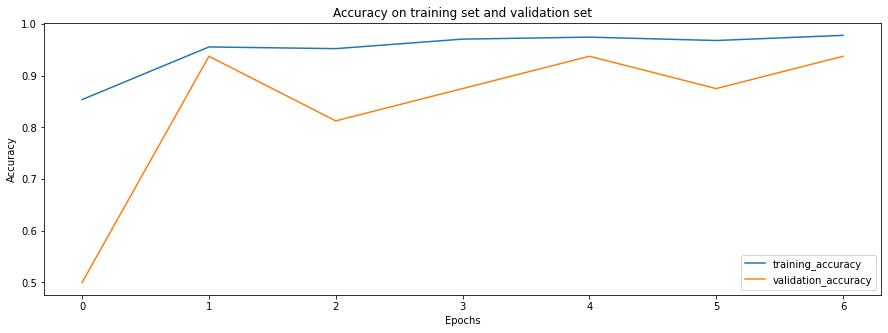

In [47]:
fig = plt.figure(figsize = (15,5))
plt.plot(history_vgg_16.history['accuracy'])                   # accuracy for the training set
plt.plot(history_vgg_16.history['val_accuracy'])               # sccuracy for the validate set
plt.legend(['training_accuracy', 'validation_accuracy'])
plt.title('Accuracy on training set and validation set')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [48]:
model_vgg_16.evaluate(test_dataset, verbose = 2)

10/10 - 31s - loss: 0.4257 - accuracy: 0.8846


[0.4257344901561737, 0.8846153616905212]